# Latent Dirichlet Allocation (LDA)

LDA (short for Latent Dirichlet Allocation) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic.

### Notebook établi à partir de : 
- https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb 
    - https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

#### Autres ressources intéressantes

Autre article similaire sur la LDA :
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0 
    - https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb
    
- https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#1introduction

##### Aspect visualisation
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/ 

##### Scikit-learn
- https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation
- https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html


In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install langdetect
import langdetect
import nltk
!pip install gensim
import gensim
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

     |████████████████████████████████| 24.0 MB 9.3 MB/s            
     |████████████████████████████████| 58 kB 11.7 MB/s            
     |████████████████████████████████| 1.7 MB 1.3 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 829 kB 12.2 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=31c3184f4b3c217e3910f2b57de195221a2935c001bfa89f3ee9e00a7c13c97a
  Stored in directory: /home/jovyan/.cache/pip/wheels/57/a4/86/d10c6c2e0bf149fbc0afb0aa5a6528ac35b30a133a0270c477
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=a535bba13b76f51b1ad8754fc21da4188457947ab1c9949dff035757bf18ad13
  Stored in directory: /home/jovyan/.cach

/tmp/ipykernel_490/1314766803.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

# Reading data

In [4]:
#On récupère directement le dataset nettoyé
url="https://minio.lab.sspcloud.fr/aissac/Projet_Python_2A/clean_ecb_speeches_dataset.csv"

df=pd.read_csv(url,sep = ",",encoding='utf-8')

data=df.sample(frac=0.6,random_state=1) #on n'applique la LDA que sur une portion du dataset pour pouvoir tester le modèle par la suite

In [5]:
data.shape

(1400, 11)

In [6]:
data = data.dropna().reset_index(drop=True)

In [7]:
data.shape

(1400, 11)

# Cleaning

#### Keeping English articles

In [6]:
data['lang'] = data.contents.progress_map(langdetect.detect)

  0%|          | 0/1398 [00:00<?, ?it/s]

In [7]:
data.lang.value_counts()

en    1398
Name: lang, dtype: int64

In [8]:
data = data.loc[data.lang=='en']

#### Tokenization

In [9]:
data['sentences'] = data.contents.progress_map(nltk.tokenize.sent_tokenize)
data['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of the 1st article

  0%|          | 0/1398 [00:00<?, ?it/s]

['   SPEECH  Learning from Lisbon: recovery and resilience in Europe   Speech by Christine Lagarde, President of the ECB, on the occasion of the 175th anniversary of Banco de Portugal in Lisbon Lisbon, 3 November 2021 Introduction I am delighted to be here in Lisbon to celebrate the 175th anniversary of the Banco de Portugal, an institution that can be proud of its contribution to Portuguese history.',
 'And it is a history that is fused with Europe.',
 'Lisbon was home to the peaceful Carnation Revolution of 1974, which ushered in democracy and marked a crucial step towards Portugal’s membership of the European Community.']

In [10]:
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [nltk.tokenize.word_tokenize(sentence) for sentence in sentences])
print(data['tokens_sentences'].head(1).tolist()[0][:3])

  0%|          | 0/1398 [00:00<?, ?it/s]

[['SPEECH', 'Learning', 'from', 'Lisbon', ':', 'recovery', 'and', 'resilience', 'in', 'Europe', 'Speech', 'by', 'Christine', 'Lagarde', ',', 'President', 'of', 'the', 'ECB', ',', 'on', 'the', 'occasion', 'of', 'the', '175th', 'anniversary', 'of', 'Banco', 'de', 'Portugal', 'in', 'Lisbon', 'Lisbon', ',', '3', 'November', '2021', 'Introduction', 'I', 'am', 'delighted', 'to', 'be', 'here', 'in', 'Lisbon', 'to', 'celebrate', 'the', '175th', 'anniversary', 'of', 'the', 'Banco', 'de', 'Portugal', ',', 'an', 'institution', 'that', 'can', 'be', 'proud', 'of', 'its', 'contribution', 'to', 'Portuguese', 'history', '.'], ['And', 'it', 'is', 'a', 'history', 'that', 'is', 'fused', 'with', 'Europe', '.'], ['Lisbon', 'was', 'home', 'to', 'the', 'peaceful', 'Carnation', 'Revolution', 'of', '1974', ',', 'which', 'ushered', 'in', 'democracy', 'and', 'marked', 'a', 'crucial', 'step', 'towards', 'Portugal', '’', 's', 'membership', 'of', 'the', 'European', 'Community', '.']]


#### Lemmatizing with POS tagging

In [11]:
#################################################################

# ETAPE LA PLUS CHRONOPHAGE
# 4 minutes pour 1400 discours

################################################################

data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [nltk.pos_tag(tokens) for tokens in tokens_sentences])
print(data['POS_tokens'].head(1).tolist()[0][:3])

  0%|          | 0/1398 [00:00<?, ?it/s]

[[('SPEECH', 'NNP'), ('Learning', 'NNP'), ('from', 'IN'), ('Lisbon', 'NNP'), (':', ':'), ('recovery', 'NN'), ('and', 'CC'), ('resilience', 'NN'), ('in', 'IN'), ('Europe', 'NNP'), ('Speech', 'NNP'), ('by', 'IN'), ('Christine', 'NNP'), ('Lagarde', 'NNP'), (',', ','), ('President', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('ECB', 'NNP'), (',', ','), ('on', 'IN'), ('the', 'DT'), ('occasion', 'NN'), ('of', 'IN'), ('the', 'DT'), ('175th', 'JJ'), ('anniversary', 'NN'), ('of', 'IN'), ('Banco', 'NNP'), ('de', 'FW'), ('Portugal', 'NNP'), ('in', 'IN'), ('Lisbon', 'NNP'), ('Lisbon', 'NNP'), (',', ','), ('3', 'CD'), ('November', 'NNP'), ('2021', 'CD'), ('Introduction', 'NNP'), ('I', 'PRP'), ('am', 'VBP'), ('delighted', 'VBN'), ('to', 'TO'), ('be', 'VB'), ('here', 'RB'), ('in', 'IN'), ('Lisbon', 'NNP'), ('to', 'TO'), ('celebrate', 'VB'), ('the', 'DT'), ('175th', 'JJ'), ('anniversary', 'NN'), ('of', 'IN'), ('the', 'DT'), ('Banco', 'NNP'), ('de', 'FW'), ('Portugal', 'NNP'), (',', ','), ('an', 'DT'), ('ins

In [12]:
# Inspired from https://stackoverflow.com/a/15590384

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return ''

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

In [13]:
# Lemmatizing each word with its POS tag, in each sentence
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

  0%|          | 0/1398 [00:00<?, ?it/s]

In [14]:
data['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

[['SPEECH',
  'Learning',
  'from',
  'Lisbon',
  ':',
  'recovery',
  'and',
  'resilience',
  'in',
  'Europe',
  'Speech',
  'by',
  'Christine',
  'Lagarde',
  ',',
  'President',
  'of',
  'the',
  'ECB',
  ',',
  'on',
  'the',
  'occasion',
  'of',
  'the',
  '175th',
  'anniversary',
  'of',
  'Banco',
  'de',
  'Portugal',
  'in',
  'Lisbon',
  'Lisbon',
  ',',
  '3',
  'November',
  '2021',
  'Introduction',
  'I',
  'be',
  'delight',
  'to',
  'be',
  'here',
  'in',
  'Lisbon',
  'to',
  'celebrate',
  'the',
  '175th',
  'anniversary',
  'of',
  'the',
  'Banco',
  'de',
  'Portugal',
  ',',
  'an',
  'institution',
  'that',
  'can',
  'be',
  'proud',
  'of',
  'its',
  'contribution',
  'to',
  'Portuguese',
  'history',
  '.'],
 ['And',
  'it',
  'be',
  'a',
  'history',
  'that',
  'be',
  'fuse',
  'with',
  'Europe',
  '.'],
 ['Lisbon',
  'be',
  'home',
  'to',
  'the',
  'peaceful',
  'Carnation',
  'Revolution',
  'of',
  '1974',
  ',',
  'which',
  'usher',
  

#### Regrouping tokens and removing stop words

In [15]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
my_stopwords = nltk.corpus.stopwords.words('English') + stopwords_verbs + stopwords_other

In [16]:
from itertools import chain # to flatten list of sentences of tokens into list of tokens

In [17]:
data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [18]:
data['tokens'].head(1).tolist()[0][:30]

['speech',
 'learning',
 'lisbon',
 'recovery',
 'resilience',
 'europe',
 'speech',
 'christine',
 'lagarde',
 'president',
 'ecb',
 'occasion',
 'anniversary',
 'banco',
 'portugal',
 'lisbon',
 'lisbon',
 'november',
 'introduction',
 'delight',
 'lisbon',
 'celebrate',
 'anniversary',
 'banco',
 'portugal',
 'institution',
 'proud',
 'contribution',
 'portuguese',
 'history']

# LDA

## Data preparation

#### Prepare bi-grams and tri-grams

In [19]:
tokens = data['tokens'].tolist()
bigram_model = gensim.models.Phrases(tokens)
trigram_model = gensim.models.Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Prepare objects for LDA gensim implementation

In [20]:
dictionary_LDA = gensim.corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

## Running LDA

In [74]:
np.random.seed(123456)
num_topics = 9
%time lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 23.5 s


## Quick exploration of LDA results

#### Looking at topics

In [75]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.009*"statistic" + 0.004*"data" + 0.004*"monetary" + 0.004*"think" + 0.004*"information" + 0.003*"financial_stability" + 0.003*"analysis" + 0.003*"strategy" + 0.002*"money" + 0.002*"currency" + 0.002*"financial_system" + 0.002*"question" + 0.002*"indicator" + 0.002*"duisenberg" + 0.002*"eurosystem" + 0.002*"integration" + 0.002*"international" + 0.002*"experience" + 0.002*"liquidity" + 0.002*"world"

1: 0.004*"model" + 0.003*"expectation" + 0.003*"uncertainty" + 0.003*"shock" + 0.003*"international" + 0.002*"might" + 0.002*"inflation_expectation" + 0.002*"data" + 0.002*"liquidity" + 0.002*"domestic" + 0.002*"rise" + 0.002*"response" + 0.002*"instrument" + 0.002*"united_states" + 0.002*"chart" + 0.002*"factor" + 0.002*"recovery" + 0.002*"likely" + 0.002*"estimate" + 0.002*"affect"

2: 0.008*"sepa" + 0.005*"payment" + 0.003*"eurosystem" + 0.003*"liquidity" + 0.003*"retail_payment" + 0.002*"new_member_states" + 0.002*"service" + 0.002*"international" + 0.002*"strategy" + 0.002*"financ

#### Allocating topics to documents

In [76]:
print(data.contents.loc[0][:500])

   SPEECH  Learning from Lisbon: recovery and resilience in Europe   Speech by Christine Lagarde, President of the ECB, on the occasion of the 175th anniversary of Banco de Portugal in Lisbon Lisbon, 3 November 2021 Introduction I am delighted to be here in Lisbon to celebrate the 175th anniversary of the Banco de Portugal, an institution that can be proud of its contribution to Portuguese history. And it is a history that is fused with Europe. Lisbon was home to the peaceful Carnation Revolutio


In [77]:
lda_model[corpus[0]]

[(1, 0.10614286), (3, 0.89374834)]

#### Predicting topics on unseen documents

In [78]:
document = '''The Governing Council judges that the progress on economic recovery and towards its medium-term inflation target permits a step-by-step reduction in the pace of its asset purchases over the coming quarters. But monetary accommodation is still needed for inflation to stabilise at the 2% inflation target over the medium term. In view of the current uncertainty, the Governing Council needs to maintain flexibility and optionality in the conduct of monetary policy. With this is mind, the Governing Council took the following decisions:

Pandemic emergency purchase programme (PEPP)
In the first quarter of 2022, the Governing Council expects to conduct net asset purchases under the PEPP at a lower pace than in the previous quarter. It will discontinue net asset purchases under the PEPP at the end of March 2022.

The Governing Council decided to extend the reinvestment horizon for the PEPP. It now intends to reinvest the principal payments from maturing securities purchased under the PEPP until at least the end of 2024. In any case, the future roll-off of the PEPP portfolio will be managed to avoid interference with the appropriate monetary policy stance.

The pandemic has shown that, under stressed conditions, flexibility in the design and conduct of asset purchases has helped to counter the impaired transmission of monetary policy and made efforts to achieve the Governing Council’s goal more effective. Within our mandate, under stressed conditions, flexibility will remain an element of monetary policy whenever threats to monetary policy transmission jeopardise the attainment of price stability. In particular, in the event of renewed market fragmentation related to the pandemic, PEPP reinvestments can be adjusted flexibly across time, asset classes and jurisdictions at any time. This could include purchasing bonds issued by the Hellenic Republic over and above rollovers of redemptions in order to avoid an interruption of purchases in that jurisdiction, which could impair the transmission of monetary policy to the Greek economy while it is still recovering from the fallout of the pandemic. Net purchases under the PEPP could also be resumed, if necessary, to counter negative shocks related to the pandemic.

Asset purchase programme (APP)
In line with a step-by-step reduction in asset purchases and to ensure that the monetary policy stance remains consistent with inflation stabilising at its target over the medium term, the Governing Council decided on a monthly net purchase pace of €40 billion in the second quarter and €30 billion in the third quarter under the APP. From October 2022 onwards, the Governing Council will maintain net asset purchases under the APP at a monthly pace of €20 billion for as long as necessary to reinforce the accommodative impact of its policy rates. The Governing Council expects net purchases to end shortly before it starts raising the key ECB interest rates.

The Governing Council also intends to continue reinvesting, in full, the principal payments from maturing securities purchased under the APP for an extended period of time past the date when it starts raising the key ECB interest rates and, in any case, for as long as necessary to maintain favourable liquidity conditions and an ample degree of monetary accommodation.

Key ECB interest rates
The interest rate on the main refinancing operations and the interest rates on the marginal lending facility and the deposit facility will remain unchanged at 0.00%, 0.25% and -0.50% respectively.

In support of its symmetric 2% inflation target and in line with its monetary policy strategy, the Governing Council expects the key ECB interest rates to remain at their present or lower levels until it sees inflation reaching 2% well ahead of the end of its projection horizon and durably for the rest of the projection horizon, and it judges that realised progress in underlying inflation is sufficiently advanced to be consistent with inflation stabilising at 2% over the medium term. This may also imply a transitory period in which inflation is moderately above target.

Refinancing operations
The Governing Council will continue to monitor bank funding conditions and ensure that the maturing of operations under the third series of targeted longer-term refinancing operations (TLTRO III) does not hamper the smooth transmission of its monetary policy. The Governing Council will also regularly assess how targeted lending operations are contributing to its monetary policy stance. As announced, it expects the special conditions applicable under TLTRO III to end in June next year. The Governing Council will also assess the appropriate calibration of its two-tier system for reserve remuneration so that the negative interest rate policy does not limit banks’ intermediation capacity in an environment of ample excess liquidity.

***

The Governing Council stands ready to adjust all of its instruments, as appropriate and in either direction, to ensure that inflation stabilises at its 2% target over the medium term.

The President of the ECB will comment on the considerations underlying these decisions at a press conference starting at 14:30 CET today.'''
tokens = nltk.tokenize.word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,1,0.80,"0.004*""model"" + 0.003*""expectation"" + 0.003*""u..."
1,4,0.03,"0.004*""integration"" + 0.003*""financial_integra..."
2,6,0.03,"0.007*""liquidity"" + 0.004*""financial_system"" +..."
3,7,0.13,"0.005*""monetary"" + 0.004*""currency"" + 0.004*""i..."


## Advanced exploration of LDA results

#### Allocation of topics in all documents

In [79]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [80]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], num_topics)

,0,1,2,3,4,5,6,7,8,9,15,18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038537,0.091301,0.869287


In [81]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [82]:
document_topic.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.105843,0.000000,0.894049,0.000000,0.000000,0.0,0.000000,0.000000
1,0.0,0.033863,0.011571,0.000000,0.116983,0.416051,0.0,0.000000,0.421487
2,0.0,0.000000,0.000000,0.000000,0.277752,0.000000,0.0,0.721339,0.000000
3,0.0,0.000000,0.000000,0.222240,0.777524,0.000000,0.0,0.000000,0.000000
4,0.0,0.399262,0.000000,0.000000,0.600590,0.000000,0.0,0.000000,0.000000


In [83]:
print("Moyenne de la part de chaque topic dans tout le texte")
for i in range(num_topics):
    print("Topic", i,":", document_topic.sort_values(i, ascending=False)[i].mean())

Moyenne de la part de chaque topic dans tout le texte
Topic 0 : 0.04982995848972164
Topic 1 : 0.11377042040191537
Topic 2 : 0.0486875334801219
Topic 3 : 0.08980640219138117
Topic 4 : 0.23849627264350312
Topic 5 : 0.07228218345770956
Topic 6 : 0.07050361746365207
Topic 7 : 0.20091352170434526
Topic 8 : 0.11476201575065567


In [84]:
# Which document are about topic 1
document_topic.sort_values(1, ascending=False)[1]

151     0.999963
132     0.999956
37      0.999949
973     0.999944
998     0.999936
          ...   
544     0.000000
542     0.000000
541     0.000000
540     0.000000
1397    0.000000
Name: 1, Length: 1398, dtype: float64

In [85]:
print(data.contents.loc[91][:1000])

  The importance of independent fiscal councils   Opening remarks by Benoît Cœuré, Member of the Executive Board of the ECB, at the workshop on “Fiscal councils, central banks and sound public finances”, Frankfurt am Main, 27 January 2016  ***   Setting the stage for a workshop at the ECB on fiscal councils, central banks and sound public finances, Benoît Cœuré underlines in his opening remarks that sound public finances in all euro area member countries is a precondition for completing Economic and Monetary Union. Even if these days “there is no appetite for moving towards a ‘United States of Europe’”, he says, “there is a common understanding” that euro area member countries need to further integrate their fiscal and economic policies. Benoît Cœuré focuses on the requirements that need to be met for national fiscal councils and the European Fiscal Board (EFB) to be fully effective. “Independence” is the key word at both national and European levels. The EFB is also charged with the i

#### Looking at the distribution of topics in all documents

C:\Users\Antoine\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\Antoine\anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


<AxesSubplot:>

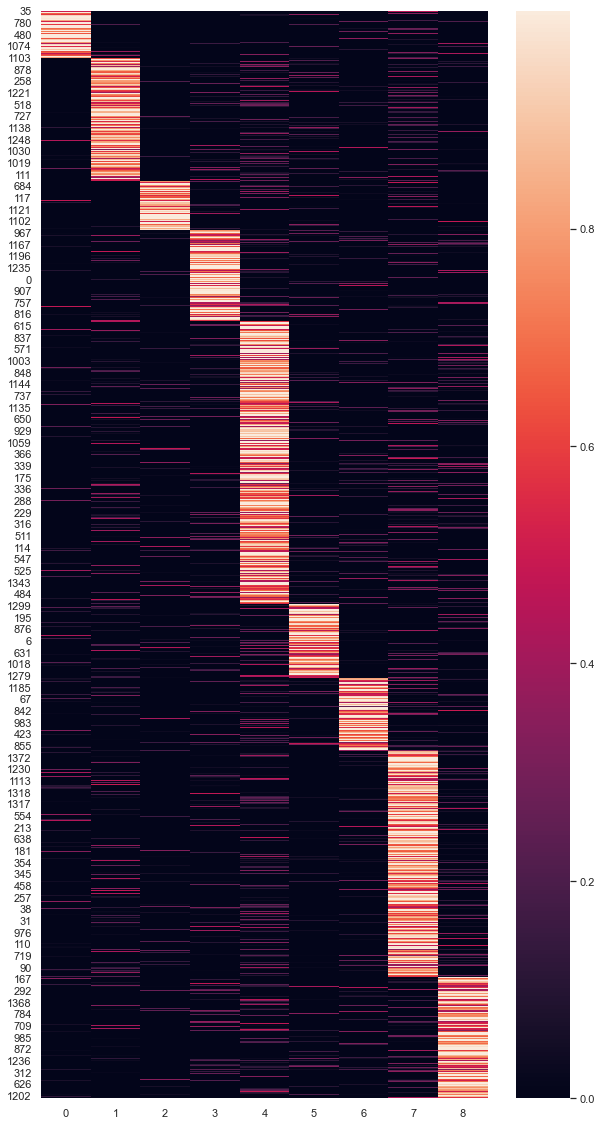

In [86]:
%matplotlib inline
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

<AxesSubplot:>

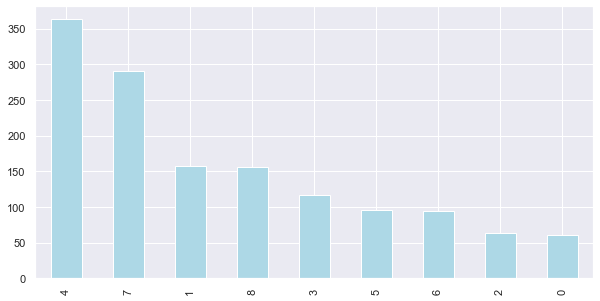

In [87]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#### Visualizing topics

In [88]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline

vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

C:\Users\Antoine\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


## Perplexity et Coherence

In [89]:

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data['tokens'].tolist(),corpus=corpus, dictionary=dictionary_LDA, coherence='u_mass')
# coherence={'u_mass', 'c_v', 'c_uci', 'c_npmi'}
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_model_lda.get_coherence_per_topic())
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.538993917475457
[-0.9335880694835187, -0.8681291095412934, -1.3619862822090365, -0.8813002352273499, -0.7816061520065525, -0.8821625851993592, -0.8108897247678897, -0.7817865929455753, -0.8023044800176798]

Coherence Score:  -0.9004170257109172


In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute 'u_mass' coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    complexity_values : Complexity values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    complexity_values= []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        complexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, complexity_values

In [41]:
#########################################

# ETAPE CHRONOPHAGE (~10 minutes)

##########################################

start_time=time.time()

model_list, coherence_values, complexity_values = compute_coherence_values(dictionary=dictionary_LDA,
                                                                           corpus=corpus,
                                                                           texts=data['tokens'].tolist(),
                                                                           start=2,
                                                                           limit=20,
                                                                           step=1
                                                                          )
print("Temps pris par cette étape", time.time()-start_time) Temps pris par cette étape 509.70097303390503

Temps pris par cette étape 509.70097303390503


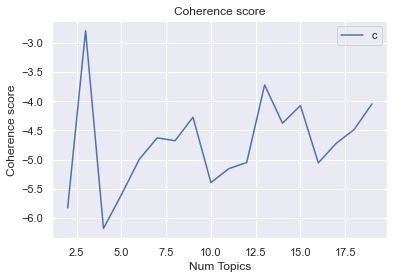

In [42]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

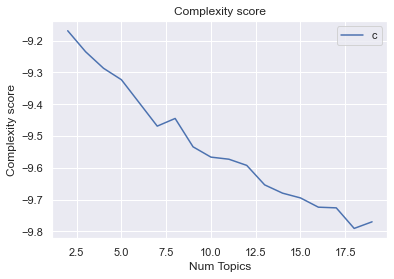

In [43]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, complexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Complexity score")
plt.title("Complexity score")
plt.legend(("complexity_values"), loc='best')
plt.show()